In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from tqdm import tqdm
import random

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

from utils import set_random_seed
set_random_seed(seed=0)

In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 784)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = F.tanh(self.fc1(z))
        z = F.tanh(self.fc2(z))
        return z


class SimpleAE(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(SimpleAE, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        o = self.decoder(z)
        return o
    
    def loss_fn(self, x: torch.Tensor, x_hat: torch.Tensor) -> float:
        mse = torch.sum((x - x_hat)**2) # by batch
        return mse
    
    def reg_weights_loss_fn(self, lam: float) -> float:
        learnable_weights = [p for p in self.parameters() if p.requires_grad and p.dim() > 1]
        loss = lam * torch.sum(torch.tensor([torch.sum(w**2) for w in learnable_weights]))
        return loss
    
    def reg_clarity_loss_fn(self, lam: float, x_hat: torch.Tensor) -> float:
        # penalize pixels close to 0
        # to make generated image more contrast
        clear_loss = lam * torch.sum((1 + x_hat) * (1 - x_hat)) # by batch
        return clear_loss

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(), # [0,1]
    transforms.Normalize(mean=(0.5,), std=(0.5,)) # [-1,1]
])

dataset = torchvision.datasets.MNIST(root='../../data/', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True, drop_last=True)

for x, _ in tqdm(dataloader):
    print(x.size())
    break

  0%|          | 0/468 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28])


In [12]:
epochs = 5
latent_dim = 16

device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder = SimpleAE(latent_dim).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

for epoch in range(epochs):
    for batch, (x, _) in enumerate(dataloader):
        
        x = torch.flatten(x, start_dim=1, end_dim=-1) # [B, 1, 784]
        x = x.to(device)
        x_hat = autoencoder(x) # [B, 1, 784]

        loss = autoencoder.loss_fn(x, x_hat)
        reg_weights_loss = autoencoder.reg_weights_loss_fn(lam=1e-2)
        reg_clarity_loss = autoencoder.reg_clarity_loss_fn(x_hat=x_hat, lam=1e-1)
        total_loss = loss + reg_weights_loss + reg_clarity_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            print(
                f"epoch={epoch}",
                f"batch={batch:03d}", 
                f"mse={loss.item():.2f}", 
                f"reg_weights={reg_weights_loss.item():.2f}", 
                f"reg_clarity={reg_clarity_loss.item():.2f}",
                f"total_loss={total_loss.item():.2f}"
            )

    print()

epoch=0 batch=000 mse=95016.12 reg_weights=3.52 reg_clarity=9894.20 total_loss=104913.85
epoch=0 batch=100 mse=24350.76 reg_weights=4.33 reg_clarity=3196.70 total_loss=27551.80
epoch=0 batch=200 mse=19226.40 reg_weights=5.04 reg_clarity=2837.57 total_loss=22069.01
epoch=0 batch=300 mse=16646.02 reg_weights=5.90 reg_clarity=2637.61 total_loss=19289.53
epoch=0 batch=400 mse=15657.45 reg_weights=6.71 reg_clarity=2382.36 total_loss=18046.53

epoch=1 batch=000 mse=14299.85 reg_weights=7.28 reg_clarity=2273.45 total_loss=16580.58
epoch=1 batch=100 mse=13923.02 reg_weights=8.13 reg_clarity=2202.79 total_loss=16133.93
epoch=1 batch=200 mse=12550.31 reg_weights=8.97 reg_clarity=2061.87 total_loss=14621.15
epoch=1 batch=300 mse=11500.67 reg_weights=9.86 reg_clarity=2008.34 total_loss=13518.87
epoch=1 batch=400 mse=10310.01 reg_weights=10.71 reg_clarity=1829.23 total_loss=12149.95

epoch=2 batch=000 mse=10537.92 reg_weights=11.25 reg_clarity=1814.73 total_loss=12363.91
epoch=2 batch=100 mse=10697

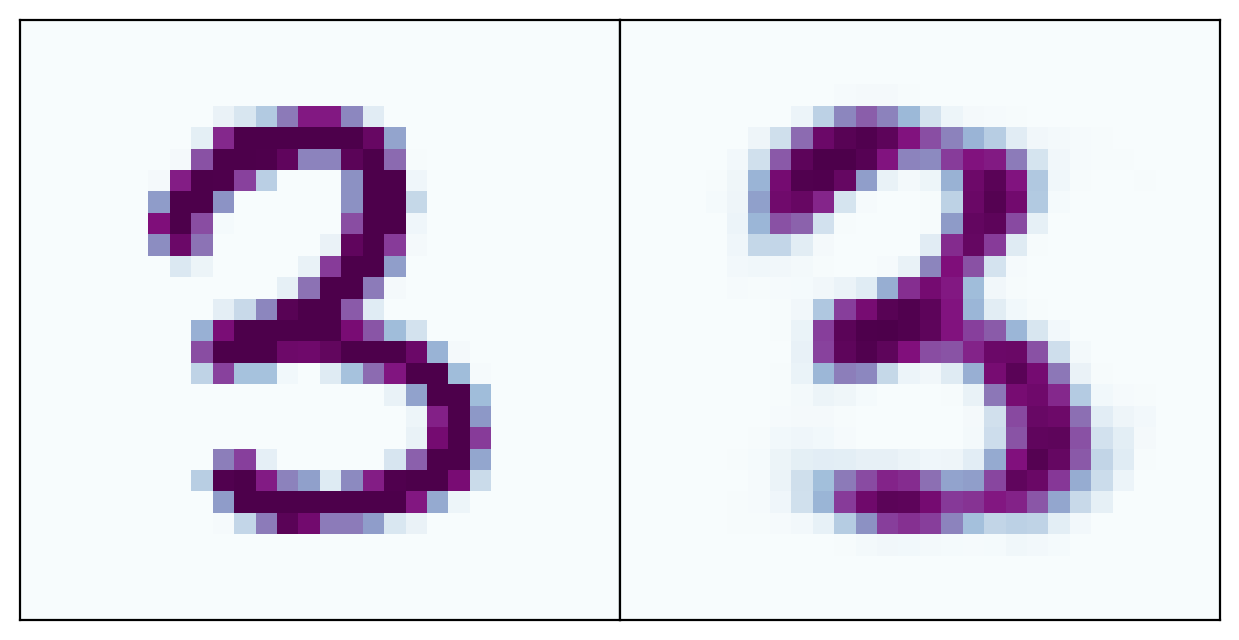

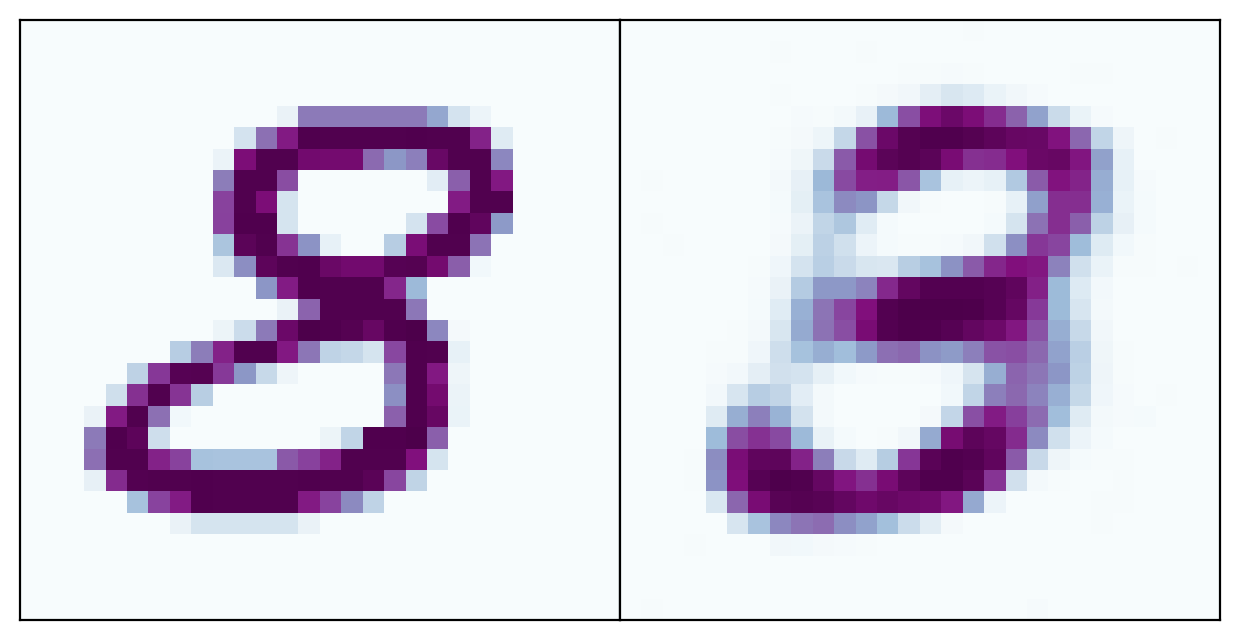

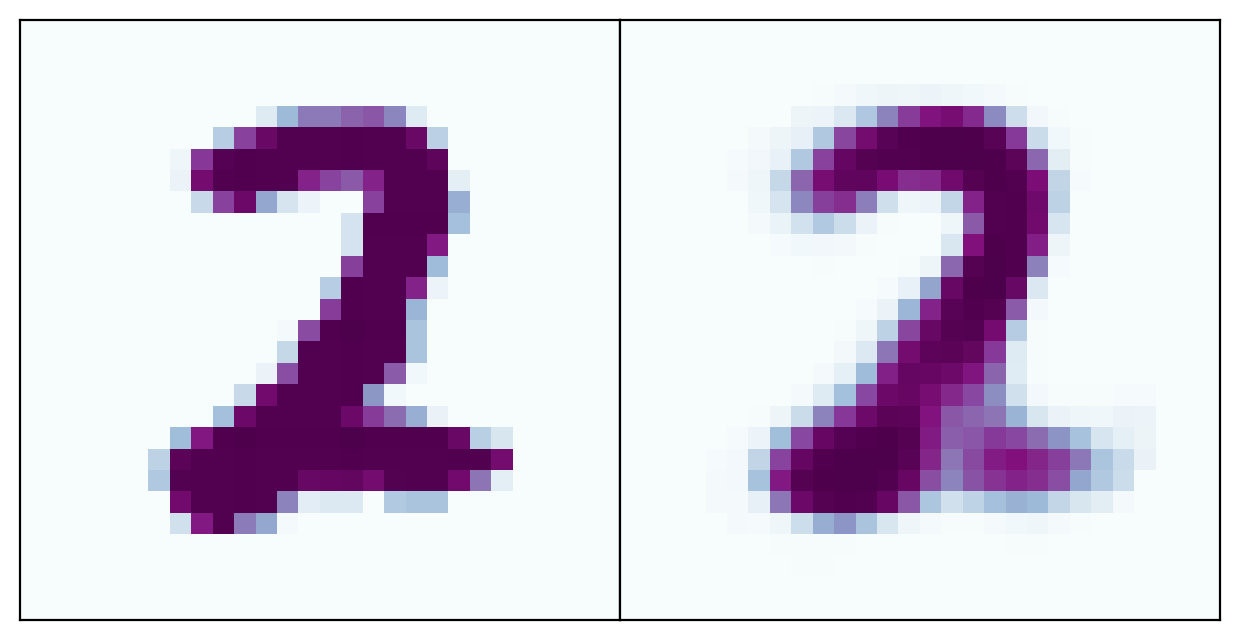

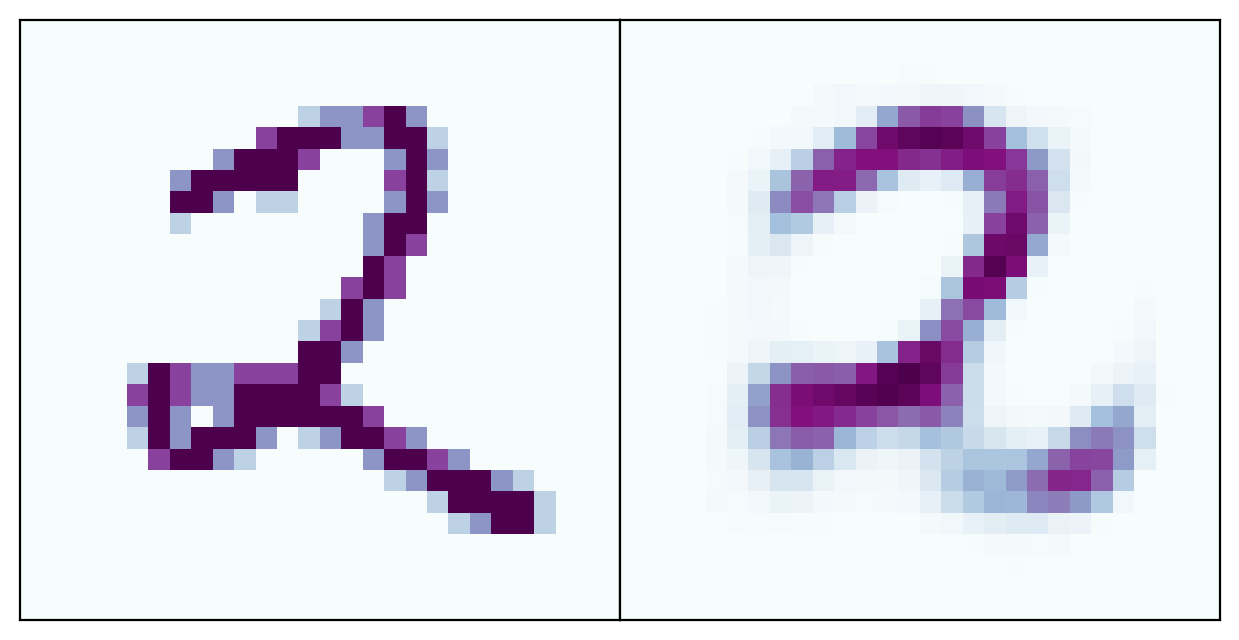

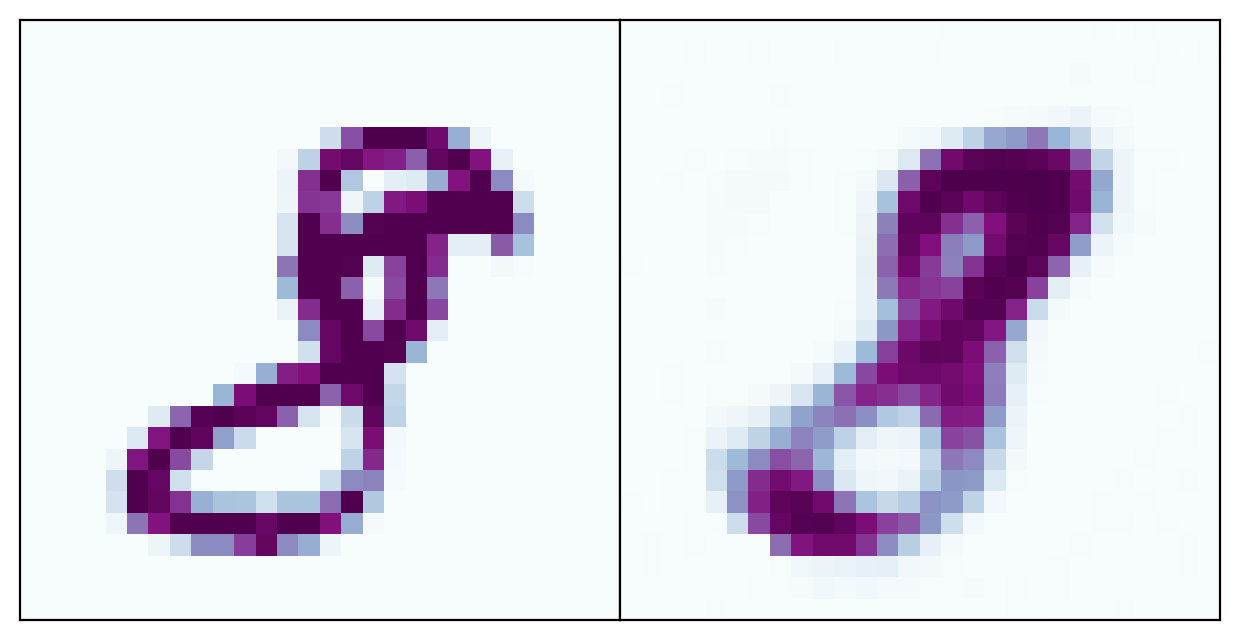

In [13]:
set_random_seed(seed=0)
imgs = [dataset[r] for r in random.sample(range(30_000), 5)]

for img, label in imgs:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(img.view(28,28), cmap='BuPu');

    img_hat = autoencoder(img.view(1,1,784).to(device))
    ax2.imshow(img_hat.view(28,28).cpu().detach(), cmap='BuPu');
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.show()